# Import all Libraries

In [297]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_decision_regions
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# Import and check data

In [298]:
rawdata = pd.read_csv("regression_data_clean.csv")
rawdata.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [299]:
rawdata.shape

(21597, 21)

In [300]:
# Convert the date column into pandas datetime for sorting.

rawdata['date'] = pd.to_datetime(rawdata['date'])

## There were a number of duplicate ids, so to give a more accurate picture of the current property market, I  used only the most recent sale data from duplicated properties.

In [301]:
rawdata = rawdata.sort_values(by=['id', 'date'])

In [302]:
rawdata = rawdata.drop_duplicates(['id'], keep='last')

In [303]:
rawdata_duplicates = rawdata[rawdata.duplicated(['id'], keep=False)]

In [304]:
rawdata_duplicates

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price


In [305]:
rawdata.shape

(21420, 21)

### Now to sort the columns with lots of 0s

In [306]:
#A function to reduce columns with limited data into boolean

def ColumnReducer (x):
    if x == 0:
        n = 0
    elif x > 0:
        n = 1
    return n


In [307]:
rawdata['waterfront'] = rawdata['waterfront'].apply(ColumnReducer)
rawdata['view'] = rawdata['view'].apply(ColumnReducer)
rawdata['sqft_basement'] = rawdata['sqft_basement'].apply(ColumnReducer)
rawdata['renovated'] = rawdata['yr_renovated'].apply(ColumnReducer)

In [308]:
rawdata.reset_index()
rawdata.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,renovated
2495,1000102,2015-04-22,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316,300000,0
6729,1200019,2014-05-08,4,1.75,2060,26036,1.0,0,0,4,8,1160,1,1947,0,98166,47.4444,-122.351,2590,21891,647500,0
8404,1200021,2014-08-11,3,1.00,1460,43000,1.0,0,0,3,7,1460,0,1952,0,98166,47.4434,-122.347,2250,20023,400000,0
8800,2800031,2015-04-01,3,1.00,1430,7599,1.5,0,0,4,6,1010,1,1930,0,98168,47.4783,-122.265,1290,10320,235000,0
3553,3600057,2015-03-19,4,2.00,1650,3504,1.0,0,0,3,7,760,1,1951,2013,98144,47.5803,-122.294,1480,3504,402500,1


### There are a number of columns that will not be help with the model so I will drop them before further exploration

In [309]:
rawdata = rawdata.drop(["id","date","lat","long","yr_renovated"], axis=1)

### The sqft_living and sqft_lot have more recent values in sqft_living15 and sqft_lot. So will drop the older values for a more up to date value of each property.

In [310]:
rawdata = rawdata.drop(["sqft_living","sqft_lot"], axis=1)

### Now for a quick look at the data

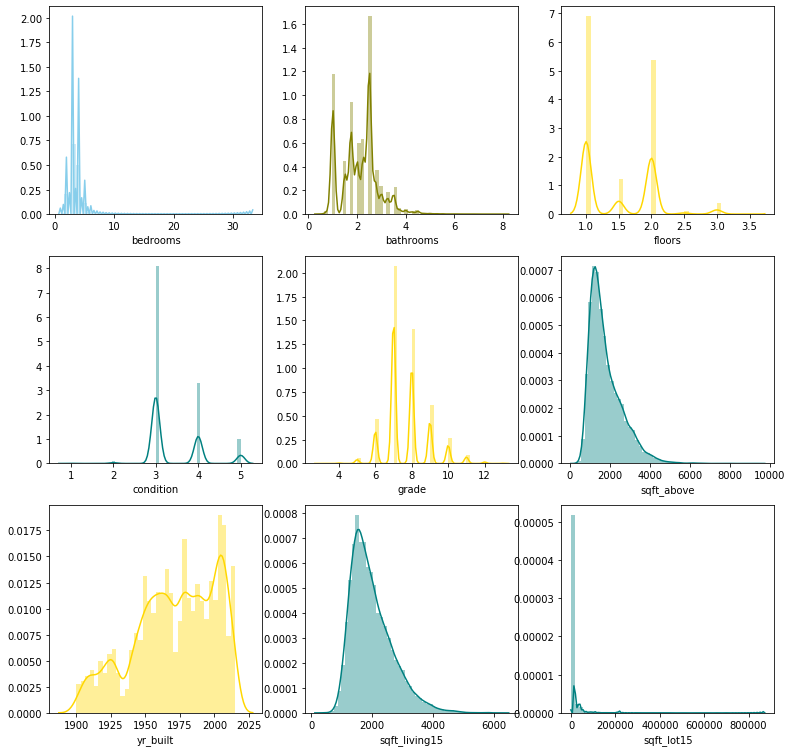

In [311]:
f, axes = plt.subplots(3, 3, figsize=(13, 13), sharex=False)
sns.distplot( rawdata["bedrooms"] , color="skyblue", ax=axes[0, 0])
sns.distplot( rawdata["bathrooms"] , color="olive", ax=axes[0, 1])
sns.distplot( rawdata["floors"] , color="gold", ax=axes[0, 2])
sns.distplot( rawdata["condition"] , color="teal", ax=axes[1, 0])
sns.distplot( rawdata["grade"] , color="gold", ax=axes[1, 1])
sns.distplot( rawdata["sqft_above"] , color="teal", ax=axes[1, 2])
sns.distplot( rawdata["yr_built"] , color="gold", ax=axes[2, 0])
sns.distplot( rawdata["sqft_living15"] , color="teal", ax=axes[2, 1])
sns.distplot( rawdata["sqft_lot15"] , color="teal", ax=axes[2, 2])

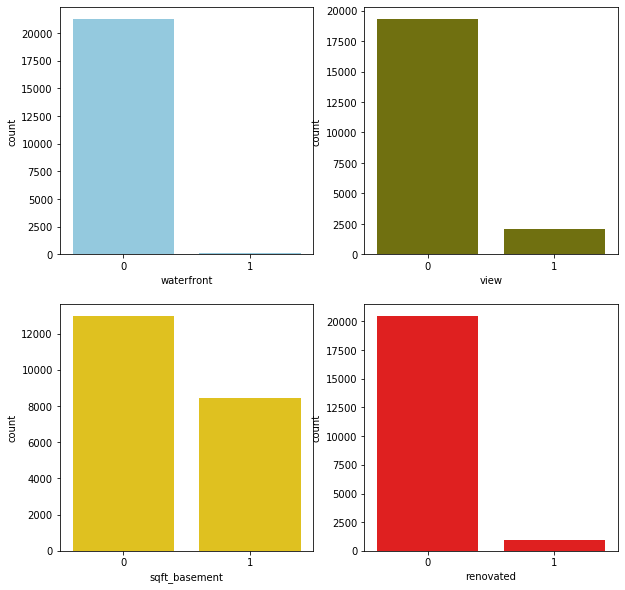

In [312]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.countplot( rawdata["waterfront"] , color="skyblue", ax=axes[0, 0])
sns.countplot( rawdata["view"] , color="olive", ax=axes[0, 1])
sns.countplot( rawdata["sqft_basement"] , color="gold", ax=axes[1, 0])
sns.countplot( rawdata["renovated"] , color="red", ax=axes[1, 1])

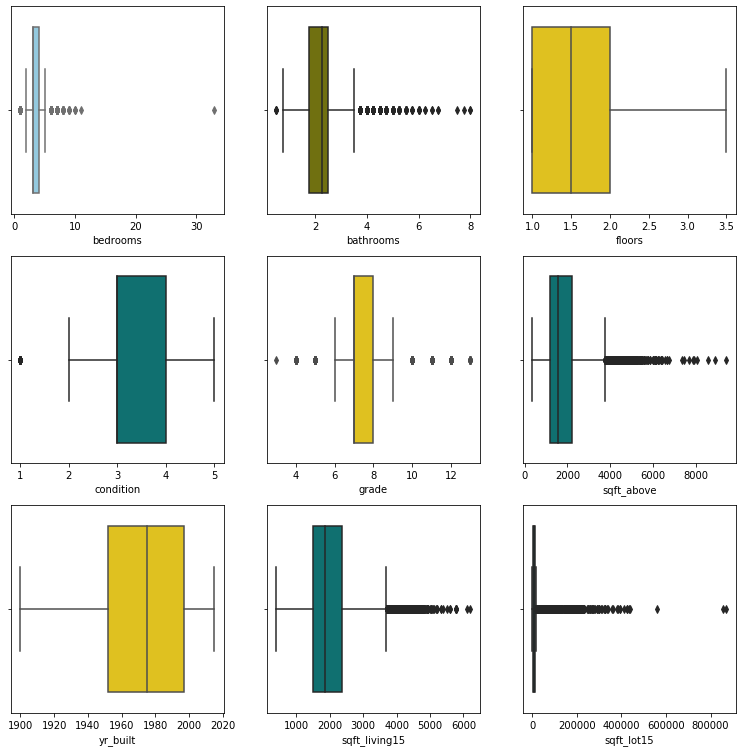

In [313]:
f, axes = plt.subplots(3, 3, figsize=(13, 13), sharex=False)
sns.boxplot( rawdata["bedrooms"] , color="skyblue", ax=axes[0, 0])
sns.boxplot( rawdata["bathrooms"] , color="olive", ax=axes[0, 1])
sns.boxplot( rawdata["floors"] , color="gold", ax=axes[0, 2])
sns.boxplot( rawdata["condition"] , color="teal", ax=axes[1, 0])
sns.boxplot( rawdata["grade"] , color="gold", ax=axes[1, 1])
sns.boxplot( rawdata["sqft_above"] , color="teal", ax=axes[1, 2])
sns.boxplot( rawdata["yr_built"] , color="gold", ax=axes[2, 0])
sns.boxplot( rawdata["sqft_living15"] , color="teal", ax=axes[2, 1])
sns.boxplot( rawdata["sqft_lot15"] , color="teal", ax=axes[2, 2])

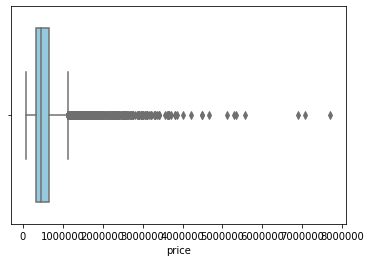

In [321]:
sns.boxplot( rawdata["price"] , color="skyblue")


In [324]:
# all_outlier_gone = rawdata[rawdata.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

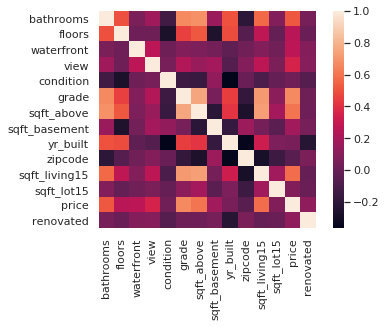

In [329]:
corr = rawdata.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()
#fig = plt.figure()
sns.set(font_scale=1)  
sns.heatmap(corr, vmax=1, square=True)

In [330]:
corr_list = corr['price'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

grade            0.666835
sqft_above       0.604424
sqft_living15    0.583792
bathrooms        0.525215
view             0.358451
waterfront       0.266995
floors           0.254972
sqft_basement    0.180120
renovated        0.126371
sqft_lot15       0.082045
yr_built         0.051012
condition        0.034219
zipcode         -0.051169
Name: price, dtype: float64

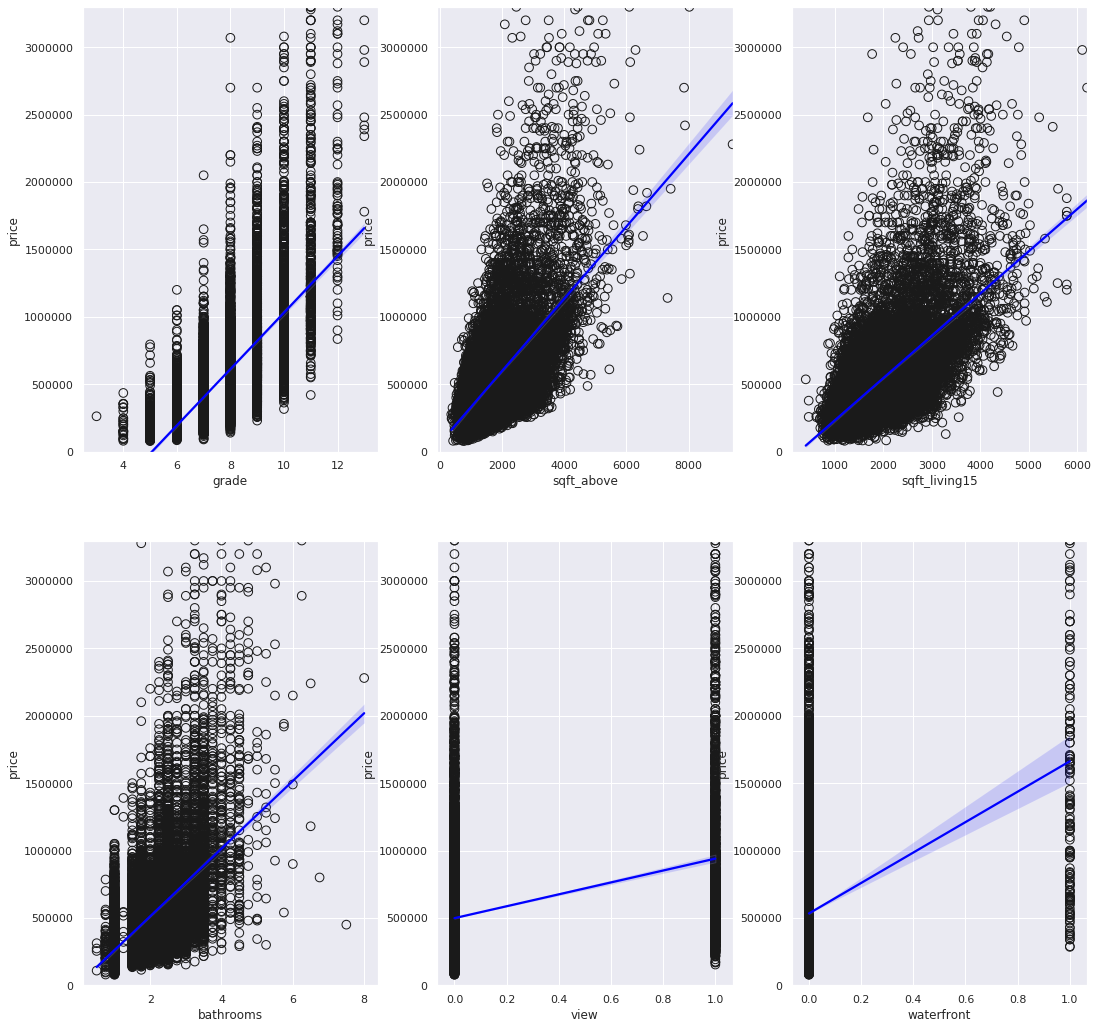

In [336]:
plt.figure(figsize=(18,18))
for i in range(6):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    feature = corr_list.index.values[i]
    plt.scatter(rawdata[feature], rawdata['price'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'price', data = rawdata,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,3300000])

In [337]:
data = rawdata.copy()

### Now for further cleaning and to deal with the outliers

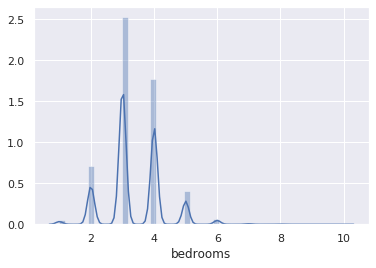

In [338]:
# The bedroom column has one massive outlier, which I will remove manually
data = data[data['bedrooms']<=10]
sns.distplot(data['bedrooms']) # Now has a slightly better distribution.

In [339]:
# The waterfront, view, and renovated columns have a big percentatge of 0 values, so will drop these entirely.
data = data.drop(["waterfront","view","renovated"], axis=1)

### Dealing with the skewed data

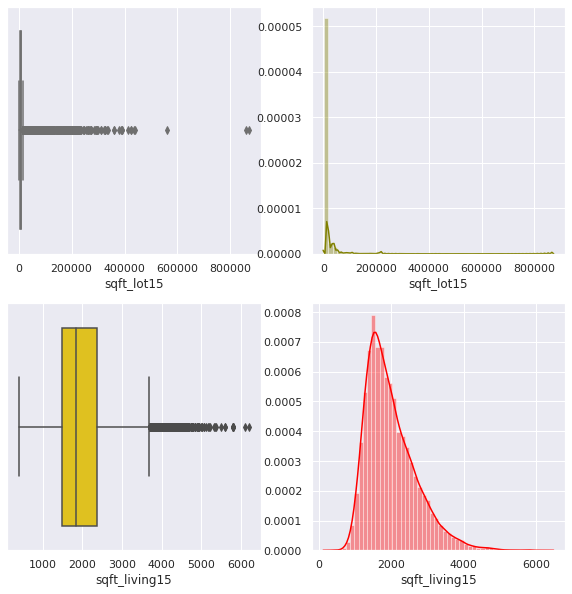

In [340]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.boxplot( data["sqft_lot15"] , color="skyblue", ax=axes[0, 0])
sns.distplot( data["sqft_lot15"] , color="olive", ax=axes[0, 1])
sns.boxplot( data["sqft_living15"] , color="gold", ax=axes[1, 0])
sns.distplot( data["sqft_living15"] , color="red", ax=axes[1, 1])

In [341]:
data["sqft_lot15_log"] = np.log(data["sqft_lot15"])
data["sqft_living15_log"] = np.log(data["sqft_living15"])

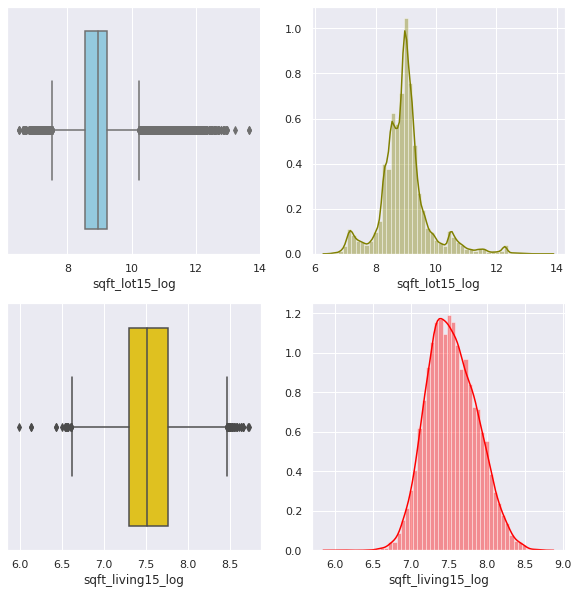

In [342]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
sns.boxplot( data["sqft_lot15_log"] , color="skyblue", ax=axes[0, 0])
sns.distplot( data["sqft_lot15_log"] , color="olive", ax=axes[0, 1])
sns.boxplot( data["sqft_living15_log"] , color="gold", ax=axes[1, 0])
sns.distplot( data["sqft_living15_log"] , color="red", ax=axes[1, 1])

In [343]:
# The sqft_living15_log gives us a more normal distribution. So will drop the original column.
#The sqft_lot15_log has a worse distribution, so will drop this too and try another method.

data = data.drop(["sqft_living15","sqft_lot15_log"], axis=1)

In [344]:
data= data[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above',
    'sqft_lot15','sqft_living15_log', 'sqft_basement','zipcode', 'yr_built','price']]

In [345]:
data.columns = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above',
       'sqft_lot15', 'sqft_living15_log', 'basement', 'zipcode',
       'yr_built', 'price']

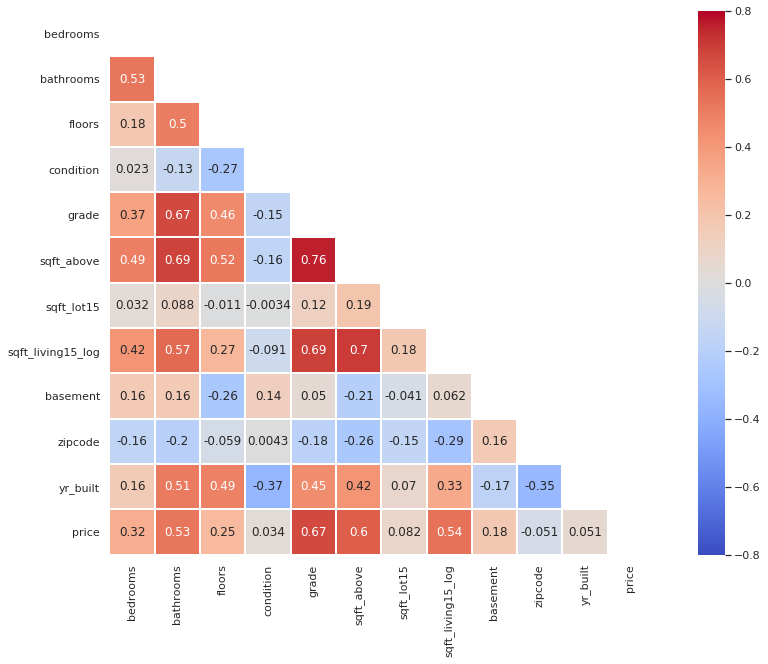

In [346]:
#A quick look at correlation may allow me to drop columns

mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8, annot=True )

In [347]:
# Looking at the heat map I can see that there are various columns with very little correlation to the price;
# These include zipcode, condition,sqdft_lot15, yr_built, basement. So will drop these now.

data = data.drop(["zipcode","condition","yr_built", "sqft_lot15", "basement"], axis=1)

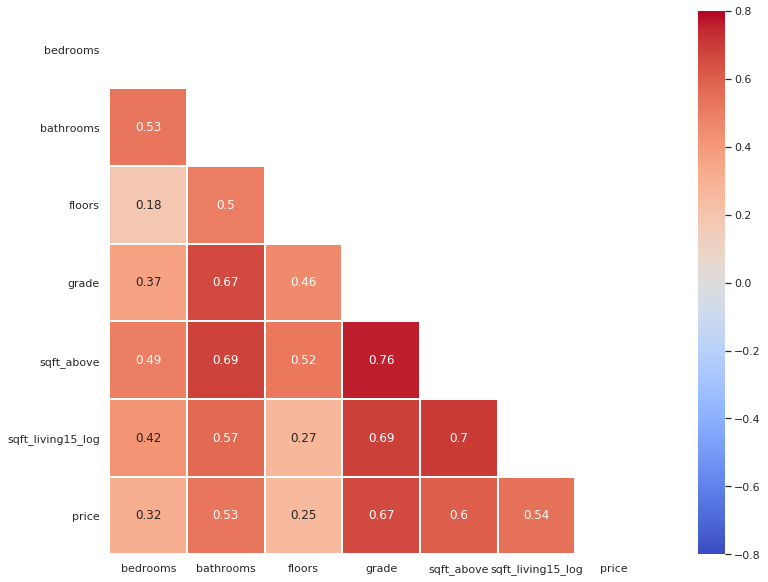

In [348]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8, annot=True )

In [349]:
# There is lots of multicollinearity with the sqft_above and other columns, so will drop that column.
data = data.drop(["sqft_above"], axis=1)

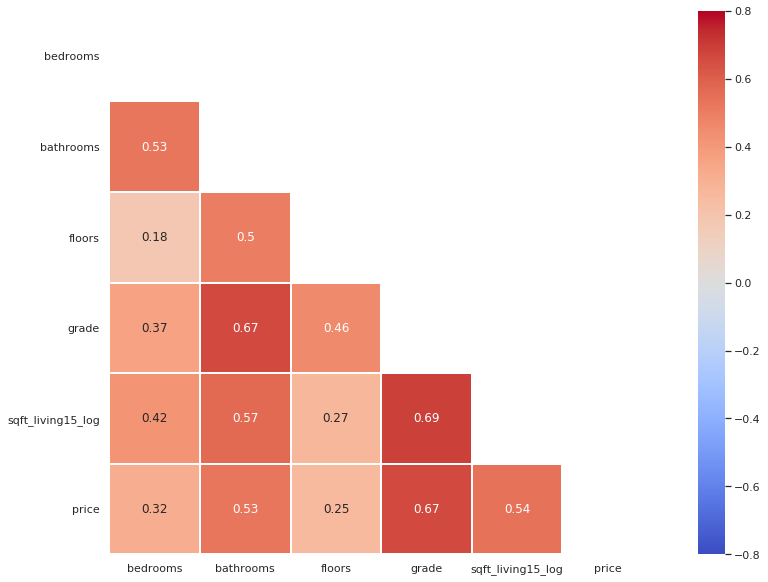

In [351]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8,annot=True )

In [352]:
data_for_model = data.copy()

In [353]:
data_for_model = data_for_model.reset_index()
data_for_model = data_for_model.drop(["index"], axis=1)
data_for_model

,bedrooms,bathrooms,floors,grade,sqft_living15_log,price
0,6,3.00,2.0,7,7.630461,300000
1,4,1.75,1.0,8,7.859413,647500
2,3,1.00,1.0,7,7.718685,400000
3,3,1.00,1.5,6,7.162397,235000
4,4,2.00,1.0,7,7.299797,402500
...,...,...,...,...,...,...
21413,5,2.00,1.5,7,7.081709,365000
21414,2,1.00,1.0,7,7.565275,380000
21415,3,1.00,1.0,7,7.319865,339000
21416,2,1.75,1.5,9,7.272398,399900


### Now I will do a quick test of the data in some regression models.

In [355]:
transformer = StandardScaler().fit(data_for_model.iloc[:,:-1])
x_standardized = transformer.transform(data_for_model.iloc[:,:-1])

In [357]:
full_standardized = pd.DataFrame(x_standardized,columns=data_for_model.columns.tolist()[:-1])
full_standardized.head()
X = full_standardized
y = data_for_model['price']

In [358]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [359]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [360]:
knn_predictions = knn_model.predict(X_test)

In [361]:
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 156817.25
The mean squared error of the model in the test set is: 64445708019.58
The root mean squared error of the model in the test set is: 253861.59
The R2 of the model in the test set is: 0.53


In [362]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)

In [363]:
lm_predictions = lm_model.predict(X_test)

In [364]:
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 170277.56
The mean squared error of the model in the test set is: 74571413555.34
The root mean squared error of the model in the test set is: 273077.67
The R2 of the model in the test set is: 0.46


In [365]:
scores = []
for i in range(2,10): 
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

Text(0, 0.5, 'R2')

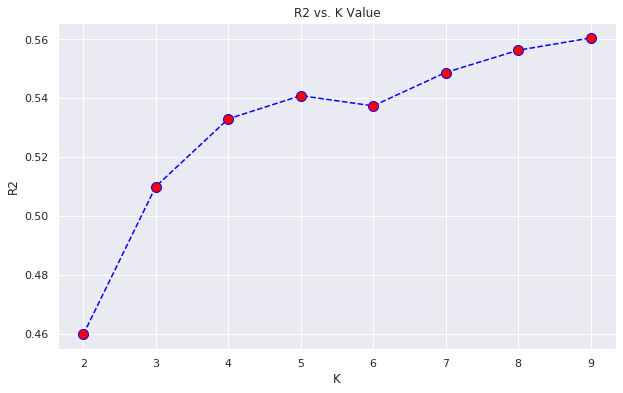

In [366]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2 vs. K Value')
plt.xlabel('K')
plt.ylabel('R2')

In [368]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 149294.20
The mean squared error of the model in the test set is: 60653401870.27
The root mean squared error of the model in the test set is: 246279.11
The R2 of the model in the test set is: 0.56


In [369]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 157502.42
The mean squared error of the model in the test set is: 65026181149.85
The root mean squared error of the model in the test set is: 255002.32
The R2 of the model in the test set is: 0.53


## Using a range of regression models, the best score was 0.55

### Now to try scaling the data and use some dummy variables.

In [370]:
data_for_scaling = data_for_model.copy()
data_for_scaling

,bedrooms,bathrooms,floors,grade,sqft_living15_log,price
0,6,3.00,2.0,7,7.630461,300000
1,4,1.75,1.0,8,7.859413,647500
2,3,1.00,1.0,7,7.718685,400000
3,3,1.00,1.5,6,7.162397,235000
4,4,2.00,1.0,7,7.299797,402500
...,...,...,...,...,...,...
21413,5,2.00,1.5,7,7.081709,365000
21414,2,1.00,1.0,7,7.565275,380000
21415,3,1.00,1.0,7,7.319865,339000
21416,2,1.75,1.5,9,7.272398,399900


In [371]:
logs_for_scaler = data_for_scaling[['sqft_living15_log']]

In [372]:
transformer = StandardScaler().fit(logs_for_scaler)
logs_standardized = transformer.transform(logs_for_scaler)
standardized = pd.DataFrame(logs_standardized)
standardized.columns = ['scaled_living15']


In [373]:
data_for_scaling = data_for_scaling.drop(["sqft_living15_log"], axis=1)

In [374]:
data_for_scaling

,bedrooms,bathrooms,floors,grade,price
0,6,3.00,2.0,7,300000
1,4,1.75,1.0,8,647500
2,3,1.00,1.0,7,400000
3,3,1.00,1.5,6,235000
4,4,2.00,1.0,7,402500
...,...,...,...,...,...
21413,5,2.00,1.5,7,365000
21414,2,1.00,1.0,7,380000
21415,3,1.00,1.0,7,339000
21416,2,1.75,1.5,9,399900


In [375]:
data_for_scaling = pd.concat([data_for_scaling,standardized],axis=1)
data_for_scaling = data_for_scaling[['bedrooms','bathrooms','floors','grade','scaled_living15','price']]
scaled_data = data_for_scaling.copy()
scaled_data

,bedrooms,bathrooms,floors,grade,scaled_living15,price
0,6,3.00,2.0,7,0.274954,300000
1,4,1.75,1.0,8,0.974185,647500
2,3,1.00,1.0,7,0.544395,400000
3,3,1.00,1.5,6,-1.154539,235000
4,4,2.00,1.0,7,-0.734912,402500
...,...,...,...,...,...,...
21413,5,2.00,1.5,7,-1.400967,365000
21414,2,1.00,1.0,7,0.075872,380000
21415,3,1.00,1.0,7,-0.673625,339000
21416,2,1.75,1.5,9,-0.818590,399900


In [376]:
# Now to try putting the scaled data through a model to see if it improves it at all

In [378]:
transformer = StandardScaler().fit(scaled_data.iloc[:,:-1])
x_standardized = transformer.transform(scaled_data.iloc[:,:-1])

In [379]:
full_standardized = pd.DataFrame(x_standardized,columns=scaled_data.columns.tolist()[:-1])
full_standardized.head()
X = full_standardized
y = scaled_data['price']

In [380]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [381]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [382]:
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 156817.25
The mean squared error of the model in the test set is: 64445708019.58
The root mean squared error of the model in the test set is: 253861.59
The R2 of the model in the test set is: 0.53


In [383]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)

In [384]:
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 170277.56
The mean squared error of the model in the test set is: 74571413555.34
The root mean squared error of the model in the test set is: 273077.67
The R2 of the model in the test set is: 0.46


In [385]:
scores = []
for i in range(2,10):
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

Text(0, 0.5, 'R2')

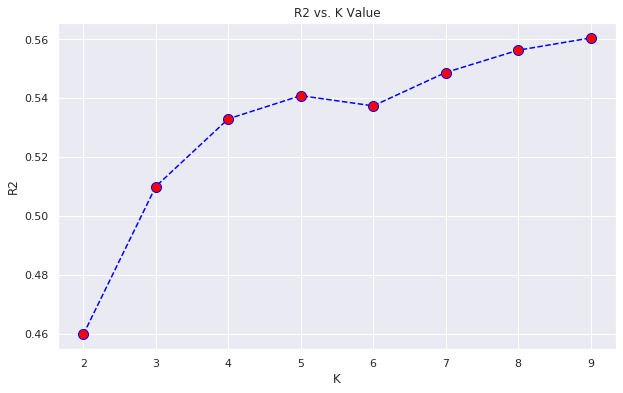

In [386]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2 vs. K Value')
plt.xlabel('K')
plt.ylabel('R2')

In [387]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 149294.20
The mean squared error of the model in the test set is: 60653401870.27
The root mean squared error of the model in the test set is: 246279.11
The R2 of the model in the test set is: 0.56


In [388]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 157502.42
The mean squared error of the model in the test set is: 65026181149.85
The root mean squared error of the model in the test set is: 255002.32
The R2 of the model in the test set is: 0.53


## This time around I got a highest score of 0.56 with the uniform model.

In [389]:
scaled_data.columns

Index(['bedrooms', 'bathrooms', 'floors', 'grade', 'scaled_living15', 'price'], dtype='object')

In [390]:
y = scaled_data['price']

#I ran the code several times, dropping different collumns to see the effect on the outcome

X = scaled_data.drop(["price",'floors'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [391]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 162758.39
The mean squared error of the model in the test set is: 68085902966.59
The root mean squared error of the model in the test set is: 260932.76
The R2 of the model in the test set is: 0.51


In [392]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)
lm_predictions = lm_model.predict(X_test)
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 170536.55
The mean squared error of the model in the test set is: 75471212964.82
The root mean squared error of the model in the test set is: 274720.24
The R2 of the model in the test set is: 0.45


In [394]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 154579.95
The mean squared error of the model in the test set is: 62923194060.98
The root mean squared error of the model in the test set is: 250844.96
The R2 of the model in the test set is: 0.54


In [395]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 164440.10
The mean squared error of the model in the test set is: 69786900228.85
The root mean squared error of the model in the test set is: 264172.10
The R2 of the model in the test set is: 0.49


In [234]:
# Now to try using some dummies

In [396]:
bathrooms = scaled_data['bathrooms']
floor = scaled_data['floors']
bedrooms = scaled_data['bedrooms']
grade = scaled_data['grade']


In [397]:
bedrooms_encoded = pd.get_dummies(bedrooms, drop_first=True)

In [398]:
bedrooms_encoded.columns = ['bed2','bed3','bed4','bed5','bed6','bed7','bed8','bed9','bed10']
bedrooms_encoded

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
21413,0,0,0,1,0,0,0,0,0
21414,1,0,0,0,0,0,0,0,0
21415,0,1,0,0,0,0,0,0,0
21416,1,0,0,0,0,0,0,0,0


In [399]:
floors_encoded = pd.get_dummies(floor, drop_first=True)
floors_encoded.columns = ['fl1.5','fl2.0','fl2.5','fl3.0','fl3.5']
floors_encoded

,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5
0,0,1,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
21413,1,0,0,0,0
21414,0,0,0,0,0
21415,0,0,0,0,0
21416,1,0,0,0,0


In [400]:
bathrooms_encoded = pd.get_dummies(bathrooms, drop_first=True)
#floors_encoded.columns = ['fl1.5','fl2.0','fl2.5','fl3.0','fl3.5']
bathrooms_encoded

,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.50,7.75,8.00
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21413,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21414,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21415,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21416,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [401]:
grade_encoded = pd.get_dummies(grade, drop_first=True)
grade_encoded.columns = ['gr4','gr5','gr6','gr7','gr8','gr9','gr10','gr11','gr12','gr13']
grade_encoded


,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
21413,0,0,0,1,0,0,0,0,0,0
21414,0,0,0,1,0,0,0,0,0,0
21415,0,0,0,1,0,0,0,0,0,0
21416,0,0,0,0,0,1,0,0,0,0


In [402]:
encoded_data = pd.concat([bedrooms_encoded,bathrooms_encoded,grade_encoded,floors_encoded],axis=1)
encoded_data

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.5,7.75,8.0,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21413,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
21414,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21415,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21416,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [403]:
for_encoded = scaled_data.drop(["bedrooms","bathrooms","floors","grade"], axis=1)

In [425]:
encoded_scaled_data = pd.concat([encoded_data,for_encoded],axis=1)
encoded_scaled_data

,bed2,bed3,bed4,bed5,bed6,bed7,bed8,bed9,bed10,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.5,7.75,8.0,gr4,gr5,gr6,gr7,gr8,gr9,gr10,gr11,gr12,gr13,fl1.5,fl2.0,fl2.5,fl3.0,fl3.5,scaled_living15,price
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.274954,300000
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.974185,647500
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.544395,400000
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,-1.154539,235000
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.734912,402500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21413,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,-1.400967,365000
21414,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.075872,380000
21415,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.673625,339000
21416,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,-0.818590,399900


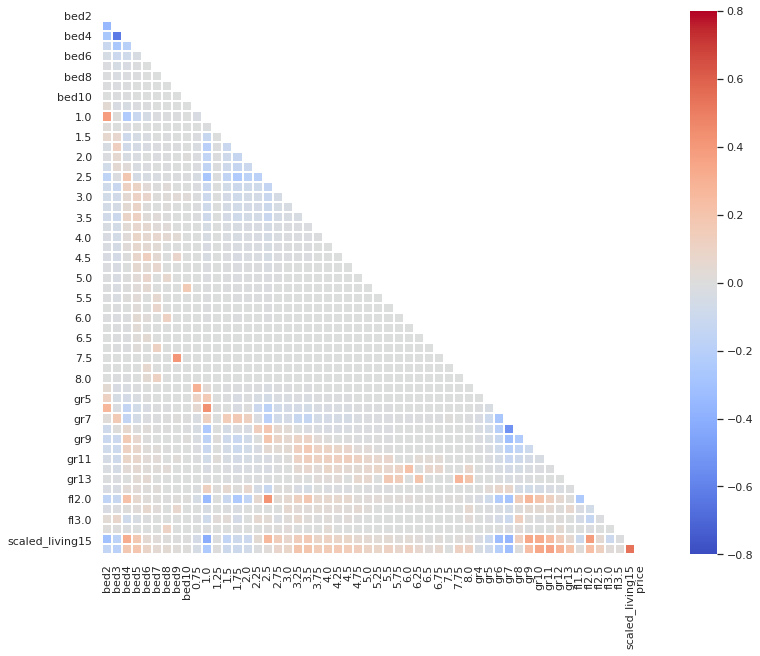

In [426]:
mask = np.zeros_like(encoded_scaled_data.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(encoded_scaled_data.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8)

In [427]:
new_try = encoded_scaled_data.drop(['bed2','bed3','bed6', 'bed7','bed8','bed8','bed9','bed10',0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,
3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.5,7.75,8.0,
'gr4','gr5','gr6','gr7','gr8','fl1.5','fl2.5','fl3.0','fl3.5'], axis=1)


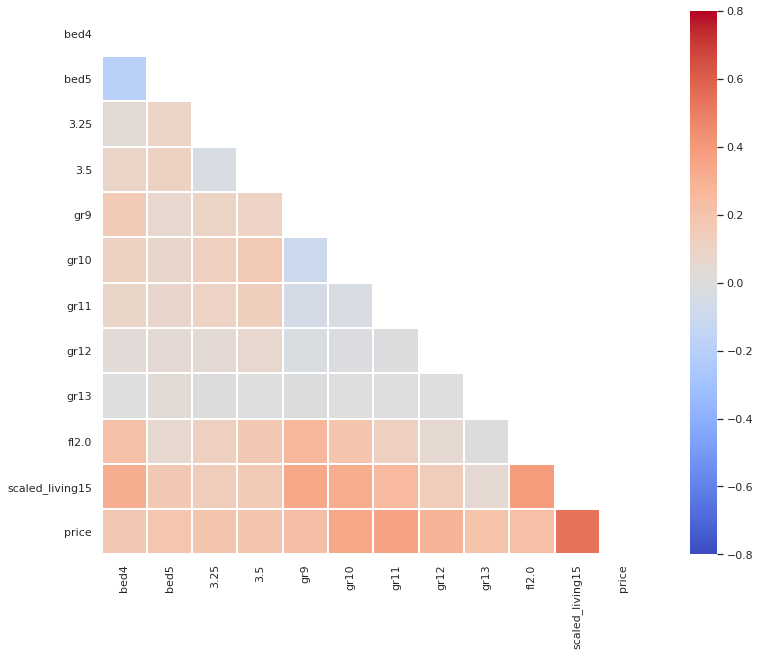

In [428]:
mask = np.zeros_like(new_try.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(new_try.corr(), mask=mask,
                     square=True, linewidths=1, cmap="coolwarm",
                     vmax = 0.8, vmin = -0.8)

In [429]:
#Now to test this in some models

In [430]:
y = new_try['price']
X = new_try.drop(["price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [431]:
y_test

21005     700000
11319     371000
13404     490000
19961     620000
17739    1010000
          ...   
9165      562000
4364      350000
11457     250000
19844     490000
15561     635000
Name: price, Length: 6426, dtype: int64

In [432]:
X_test

,bed4,bed5,3.25,3.5,gr9,gr10,gr11,gr12,gr13,fl2.0,scaled_living15
21005,0,0,0,0,0,0,0,0,0,0,-0.311662
11319,0,0,0,0,0,0,0,0,0,0,-0.440080
13404,0,0,0,0,0,0,0,0,0,0,-0.818590
19961,1,0,0,0,0,0,0,0,0,0,-0.293750
17739,1,0,0,1,1,0,0,0,0,1,0.260092
...,...,...,...,...,...,...,...,...,...,...,...
9165,0,1,0,0,0,0,0,0,0,1,0.215068
4364,0,0,0,0,0,0,0,0,0,0,-1.324929
11457,0,0,0,0,0,0,0,0,0,1,0.091655
19844,0,0,0,0,0,0,0,0,0,1,-0.137097


In [433]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
MAE = mean_absolute_error(y_test,knn_predictions)
MSE = mean_squared_error(y_test,knn_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,knn_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 174261.86
The mean squared error of the model in the test set is: 81287476723.87
The root mean squared error of the model in the test set is: 285109.59
The R2 of the model in the test set is: 0.41


In [434]:
knn_predictions

array([377250. , 329362.5, 290375. , ..., 440900. , 377750. , 502250. ])

In [435]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)
lm_predictions = lm_model.predict(X_test)
MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 162948.52
The mean squared error of the model in the test set is: 64437183555.29
The root mean squared error of the model in the test set is: 253844.80
The R2 of the model in the test set is: 0.53


In [440]:
lm_predictions

array([435948.30950792, 424261.78542665, 389815.83215519, ...,
       429726.16161973, 408908.73811082, 513240.74432581])

In [441]:
y_test

21005     700000
11319     371000
13404     490000
19961     620000
17739    1010000
          ...   
9165      562000
4364      350000
11457     250000
19844     490000
15561     635000
Name: price, Length: 6426, dtype: int64

In [442]:
uniform_model = KNeighborsRegressor(n_neighbors=9)
uniform_model.fit(X_train, y_train)
uniform_predictions = uniform_model.predict(X_test)

MAE = mean_absolute_error(y_test,uniform_predictions)
MSE = mean_squared_error(y_test,uniform_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,uniform_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 167548.61
The mean squared error of the model in the test set is: 77531608054.77
The root mean squared error of the model in the test set is: 278444.98
The R2 of the model in the test set is: 0.44


In [443]:
distance_model = KNeighborsRegressor(n_neighbors=9, weights = "distance")
distance_model.fit(X_train, y_train)
distance_predictions = distance_model.predict(X_test)

MAE = mean_absolute_error(y_test,distance_predictions)
MSE = mean_squared_error(y_test,distance_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,distance_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))

The mean absolute error of the model in the test set is: 174666.85
The mean squared error of the model in the test set is: 85352606617.18
The root mean squared error of the model in the test set is: 292151.68
The R2 of the model in the test set is: 0.38


### Using the dummy columns the highest score was 0.57 with the lm_model

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,price,renovated
2495,6,3.00,2.0,0,0,3,7,2400,0,1991,98002,2060,7316,300000,0
6729,4,1.75,1.0,0,0,4,8,1160,1,1947,98166,2590,21891,647500,0
8404,3,1.00,1.0,0,0,3,7,1460,0,1952,98166,2250,20023,400000,0
8800,3,1.00,1.5,0,0,4,6,1010,1,1930,98168,1290,10320,235000,0
3553,4,2.00,1.0,0,0,3,7,760,1,1951,98144,1480,3504,402500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16723,5,2.00,1.5,0,0,3,7,1600,0,1927,98126,1190,4168,365000,0
3257,2,1.00,1.0,0,0,5,7,840,1,1939,98126,1930,5150,380000,0
7614,3,1.00,1.0,0,0,4,7,720,1,1942,98126,1510,4538,339000,0
20963,2,1.75,1.5,0,0,3,9,900,1,2011,98027,1440,1188,399900,0
